In [1]:
import glob
import os
from os import path
import json

import tensorflow as tf
import numpy as np
import numpy.fft as fft
from PIL import Image
import matplotlib.pyplot as plt

import scipy.io as sio
import h5py

# Parameters

In [2]:
## Parameters
rank = 24
ds_psf = 2
z_slices = 1

obj_dims = (648, 486)


# Choose volume number to load
# volume_num = 4

# Filepaths

In [3]:
# Input filepaths
comps_path = '../data/PSFs/SVD_2_5um_PSF_5um_1_ds2_components_green_SubAvg.mat'
weights_path = '../data/PSFs/SVD_2_5um_PSF_5um_1_ds2_weights_interp_green_SubAvg.mat'

In [4]:
# Planes record path
planes_dir = path.join('..', 'data', '2d_data', 'tf_records', 'zebrafish_and_beads', 'ground_truths')
planes_files = glob.glob(path.join(planes_dir, '*'))

# Simulation output record path
record_dir = path.join('..', 'data', '2d_data', 'tf_records', 'zebrafish_and_beads', 'sims')

# Loading PSF, Preprocessing

In [7]:
# Read in Matlab v7.3 files with h5py.
# Stores output as comps and weights.
comps_file = h5py.File(comps_path, 'r')
for k, v in comps_file.items():
    comps = np.array(v)
    
weights_file = h5py.File(weights_path, 'r')
for k, v in weights_file.items():
    weights = np.array(v)

In [8]:
# Ensuring dtype of weights and comps is float
print(comps.dtype, weights.dtype)

float64 float64


In [9]:
# Transpose axes to get both arrays into shape (r, z, y, x)
comps = comps.transpose(1, 0, 2, 3)
weights = weights.transpose(1, 0, 2, 3)

In [10]:
r_orig, z_orig, y_orig, x_orig = comps.shape

In [11]:
print(comps.shape)

(24, 80, 1296, 972)


In [12]:
# Downsampling shape calculation. Must be flipped for use in PIL.Image.resize()
ds_shape = (np.array(comps.shape[2:]) / ds_psf).astype(int)

In [13]:
# max( sum( weights( size(weights,1)/2, size(weights,2)/2, :, :) , 4) , [] , 3);

In [14]:
# Convert each image slice into PIL image and store in array of shape (r, z)
PIL_comps_image_array = [[Image.fromarray(comps[r, z]) for z in range(z_orig)] for r in range(r_orig)]
PIL_weights_image_array = [[Image.fromarray(weights[r, z])for z in range(z_orig)] for r in range(r_orig)]

# Downsample each PIL image in the array
PIL_comps_image_array = [[PIL_comps_image_array[r][z].resize(np.flip(ds_shape), resample=Image.BOX) 
                             for z in range(z_orig)] for r in range(r_orig)]
PIL_weights_image_array = [[PIL_weights_image_array[r][z].resize(np.flip(ds_shape), resample=Image.BOX) 
                             for z in range(z_orig)] for r in range(r_orig)]

# Convert each PIL image back into numpy array, return to numpy array of shape (r, z, y, x)
comps = np.array([[np.array(PIL_comps_image_array[r][z]) for z in range(z_orig)] for r in range(r_orig)])
weights = np.array([[np.array(PIL_weights_image_array[r][z]) for z in range(z_orig)] for r in range(r_orig)])

In [15]:
# % Normalize weights to have maximum sum through rank of 1
_, _, y_new, x_new = weights.shape
weights_norm = np.max(np.sum(weights[:, :, y_new//2, x_new//2], axis=0, keepdims=True), axis=1)

# Other normalizations
weights = weights / weights_norm
comps = comps/(np.linalg.norm(comps.ravel()))

In [16]:
# PSF Preprocessing...
comps = comps[:rank]
weights = weights[:rank]
comps = comps[:, :z_slices]
weights = weights[:, :z_slices]

In [17]:
# Calculate fourier transform of H
H = fft.fft2(fft.ifftshift(fft.ifftshift(comps, axes=2), axes=3))
alpha = weights

# Forward Model

In [18]:
class ForwardModel():
    def simulate(self, v, alpha, H):
        return self._A_svd_3d(v, alpha, H)
    
    def simulate_2d(self, v, alpha, H):
        return self._A_svd_2d(v, alpha, H)
        
#     def _create_example(self, plane):
#         """
#         Creates and returns tf.Example from a given plane.
#         """
#         plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
#         feature = {
#             'plane': plane_feature
#         }
#         return tf.train.Example(features=tf.train.Features(feature=feature))
    
#     def write(self, record_file):
#         """
#         Writes all planes in dset to filename in output_dir
#         """
#         with tf.io.TFRecordWriter(record_file) as writer:
#             for plane in self.dset:
#                 tf_example = self._create_example(plane)
#                 writer.write(tf_example.SerializeToString())
                
    def _A_svd_3d(self, v, alpha, H):
        """
        Given a Fourier transformed H, calculates the convolution between H and alpha*v using FFT. 
        Sums up the results along the rank and all z-slices.
        
        Inputs:
        - H: Components of shape (r, z, y, x)
        - alpha: Weights of shape (r, z, y, x)
        - v: Object of shape (z, y, x)
        
        Outputs:
        - b: Simulated image of shape (y, x)
        """
        b = np.real(fft.ifft2(np.sum(np.sum(H*fft.fft2(v*alpha), axis=1), axis=0)))
        return b

    def _A_svd_2d(self, v, alpha, H):
        """
        Same as A_svd_3d, but reshapes v of shape (y, x) into v of shape (1, y, x)
        Given a Fourier transformed H, calculates the convolution between H and alpha*v using FFT. 
        Sums up the results along the rank and all z-slices.
        
        Inputs:
        - H: Components of shape (r, z, y, x)
        - alpha: Weights of shape (r, z, y, x)
        - v: Object of shape (y, x)
        
        Outputs:
        - b: Simulated image of shape (y, x)
        """
        y, x = v.shape
        v = v.reshape(1, y, x)
        b = np.real(fft.ifft2(np.sum(np.sum(H*fft.fft2(v*alpha), axis=1), axis=0)))
        return b

# 2D Simulations

In [23]:
raw_plane_dataset = tf.data.TFRecordDataset(filenames=planes_files)
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)
parsed_dset_2d = raw_plane_dataset.map(_parse_function)

TypeError: shuffle() missing 1 required positional argument: 'buffer_size'

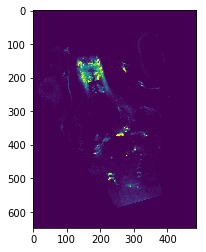

In [38]:
# Visualize a random example
dset_iterator = iter(parsed_dset_2d.shuffle(32))
plane_example = next(dset_iterator)['plane'].numpy()

plt.imshow(plane_example)

# Writing to TFRecords File

In [ ]:
model = ForwardModel()

def _create_example(plane, sim):
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=sim.ravel()))
    feature = {
        'plane': plane_feature,
        'sim': sim_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

i = 0
for sample in parsed_dset_2d:
    record_file = path.join(record_dir, 'sim-%.5d' % i)
    plane = sample['plane'].numpy()
    sim = model.simulate(plane, alpha, H).astype(np.float16)
    tf_example = _create_example(plane, sim)

    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(tf_example.SerializeToString())
    if i % 500 == 0:
        print('sim-%.5d processed' % i)
    i += 1
    
#     n = 0
#     for sample in parsed_dset_2d:
#         plane = sample['plane'].numpy()
#         sim = model.simulate(plane, alpha, H).astype(np.float16)

#         tf_example = _create_example(plane, sim)
#         writer.write(tf_example.SerializeToString())
#         n += 1
#         if n % 500 == 0:
#             print(n)

sim-00000 processed
sim-00500 processed
sim-01000 processed
sim-01500 processed
sim-02000 processed
sim-02500 processed
sim-03000 processed
sim-03500 processed
sim-04000 processed


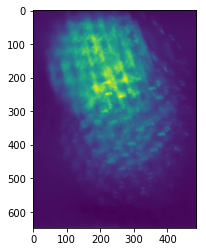

In [42]:
# Visualize sim example
sim_example = model.simulate(plane_example, alpha, H)
plt.imshow(sim_example)

# 3D Simulations

In [ ]:
dataset = np.load(dataset_path)

In [ ]:
model = ForwardModel()

n, z, y, x = dataset.shape
output_array = np.zeros((n, y, x))
for i in range(n):
    output_array[i] = model.simulate(dataset[i], alpha, H)
    print(i)

In [ ]:
output_array.shape

In [ ]:
np.save(output_path, output_array)

In [ ]:
# Input which simulation to visualize
sim_num = 3

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('2D Image')
plt.imshow(output_array[sim_num])
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
# Save output array
# sio.savemat('../data/python_output' + str(volume_num) + '_rank' + str(rank) + '.mat', dict(volume=output))

In [ ]:
# Original 'object'
from mpl_toolkits.mplot3d import Axes3D
z, y, x = np.nonzero(dataset[sim_num] > 0.1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, z, y, zdir='z')
plt.title('Original')
plt.show()

In [ ]:
# Comparison with MATLAB implementation
mat_output_path = '../data/output.mat'
mat_output = sio.loadmat(mat_output_path)
mat_output = mat_output['output'].transpose(1, 0)

In [ ]:
# Visualize mat_output
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('2D Image MATLAB')
plt.imshow(mat_output)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
# Plot reconstructed volume.

In [ ]:
reconstructed_path = '../data/reconstructedVolume.mat'
reconstructed = sio.loadmat(reconstructed_path)

In [ ]:
recons = reconstructed['xhat_out']
recons = recons.transpose(2, 1, 0)

In [ ]:
recons.shape

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

z, y, x = np.nonzero(recons > 1.5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, z, y, zdir='z')
plt.colorbar(sc)
plt.title("Reconstructed volume")
plt.show()

In [ ]:
# Original 'object'
from mpl_toolkits.mplot3d import Axes3D

z, y, x = np.nonzero(v)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, z, y, zdir='z')
plt.title('Original')
plt.show()

# Simulating real data beads

In [ ]:
from PIL import Image
import PIL
import numpy as np

In [ ]:
real_data_path = path.join('..', 'data', '2d_data', 'real_data', 'realData.mat')
ground_truth_path = path.join('..', 'data', '2d_data', 'real_data', 'beads_GT.png')

In [ ]:
beads_im = Image.open(ground_truth_path)
beads = np.array(beads_im).T

In [ ]:
# Normalize beads from 0 to 1
beads_normalized = (beads - np.min(beads)) / (np.max(beads) - np.min(beads))

In [ ]:
print(np.min(beads))

In [ ]:
print(np.max(beads))

In [ ]:
print(np.max(beads_normalized))
print(np.max(beads))

In [ ]:
model = ForwardModel()

In [ ]:
beads_sim_normalized = model.simulate_2d(beads_normalized, alpha, H)
beads_sim = model.simulate_2d(beads, alpha, H)

In [ ]:
print(np.max(beads_sim_normalized))

In [ ]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [ ]:
beads_given, resTarget = data['beads'], data['resTarget']

In [ ]:
beads_downsampled = np.array(Image.fromarray(beads_given).resize(obj_dims, resample=PIL.Image.NEAREST)).astype(np.float16)
resTarget_downsampled = np.array(Image.fromarray(resTarget).resize(np.flip(obj_dims), resample=PIL.Image.NEAREST)).astype(np.float16)

In [ ]:
np.max(beads_downsampled)

In [ ]:
np.max(beads_sim_normalized)

In [ ]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads')
f0.imshow(beads.T)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my simulation, rank 24') # Normalized before simulation, but not after
f1.imshow(beads_sim_normalized.T)


# f2 = fig.add_subplot(1, 3, 2)
# f2.set_title('beads, not normalized')
# f2.imshow(beads_sim.T)

f3 = fig.add_subplot(1, 3, 3)
f3.set_title('original')
f3.imshow(beads_downsampled.astype(np.float32))

plt.show()

In [ ]:
beads_given_normalized = (beads_downsampled - np.min(beads_given)) / (np.max(beads_downsampled) - np.min(beads_downsampled))

In [ ]:
beads_sim_normalized_normalized = (beads_sim_normalized - np.min(beads_sim_normalized)) / (np.max(beads_sim_normalized) - np.min(beads_sim_normalized))

In [ ]:
np.max(beads_given_normalized)

In [ ]:
np.max(beads_sim_normalized_normalized)

In [ ]:
num_pixels = np.prod(np.shape(beads_given_normalized))

In [ ]:
m2 = np.sum(beads_given_normalized) / num_pixels

In [ ]:
m1 = np.sum(beads_sim_normalized_normalized) / num_pixels

In [ ]:
m2 - m1

In [ ]:
(m1 - m2) * num_pixels

In [ ]:
np.save('../test', beads_sim_normalized_normalized)

In [ ]:
print(beads_downsampled.nonzero()[:5][:5])

In [ ]:
print(beads_downsampled[485, 640:645])